#### Basic ML for Price Validation & Outlier Detection

#### Goals:
- Detect price outliers (anomalous high/low values)
- Flag potentially invalid / suspicious entries
- Simple text-based grouping of similar materials
- Save flagged data for review / reports

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

# ML imports
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#### 1. Load cleaned data

In [3]:
DATA_DIR = Path("data")
CLEAN_FILE = DATA_DIR / "master_prices_cleaned_20260218.csv"

df = pd.read_csv(CLEAN_FILE, parse_dates=['last_checked_dt', 'scraped_at'])

print(f"Loaded {len(df)} rows")
df_valid = df[df['price_etb_valid']].copy()
print(f"Valid prices for ML: {len(df_valid)}")

Loaded 177 rows
Valid prices for ML: 177


#### 2. Outlier Detection with Isolation Forest

In [4]:
# Prepare features
features = df_valid[['price_etb', 'days_since_update']].copy()

# Log-transform price (handles skewness)
features['log_price'] = np.log1p(features['price_etb'].clip(lower=1))

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features[['log_price', 'days_since_update']])

# Train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.08,      # expect ~8% outliers – tune based on domain
    random_state=42
)

df_valid['outlier_score'] = iso_forest.fit_predict(X_scaled)
df_valid['is_price_outlier'] = df_valid['outlier_score'] == -1  # -1 = outlier

# Summary
outlier_count = df_valid['is_price_outlier'].sum()
print(f"Detected {outlier_count} potential price outliers ({outlier_count/len(df_valid):.1%})")

# Some examples
print("\nSample outliers (highest scores first):")
display(
    df_valid[df_valid['is_price_outlier']]
    .sort_values('price_etb', ascending=False)
    [['category', 'material_clean', 'price_etb', 'unit_standard', 'last_checked_dt', 'days_since_update']]
    .head(10)
)

Detected 15 potential price outliers (8.5%)

Sample outliers (highest scores first):


,category,material_clean,price_etb,unit_standard,last_checked_dt,days_since_update
79,Finishing,granite: 3cm thick (imported),7300.0,square_meter,2024-05-29,630
75,Finishing,"marble: 3cm thick white marble (welega, saba, ...",7100.0,square_meter,2024-05-29,630
103,Concrete Work,gravel (02) material price at crusher site,4200.0,m3,2024-08-10,557
104,Concrete Work,fino (00) material price at crusher site,4000.0,m3,2024-08-10,557
86,Finishing,porceline: 40cm x 40cm - 10mm thick,3000.0,square_meter,2024-02-01,748
95,Concrete Work,cement - ppc mesebo,2000.0,kilogram,2023-03-25,1061
93,Concrete Work,cement - opc mugar,720.0,quintal,2021-10-16,1586
100,Concrete Work,cement - opc dangote,700.0,quintal,2021-11-20,1551
98,Concrete Work,cement - opc derba,630.0,quintal,2021-12-25,1516
96,Concrete Work,cement - opc mesebo,320.0,quintal,2018-11-28,2639


#### 3. Visualize outliers

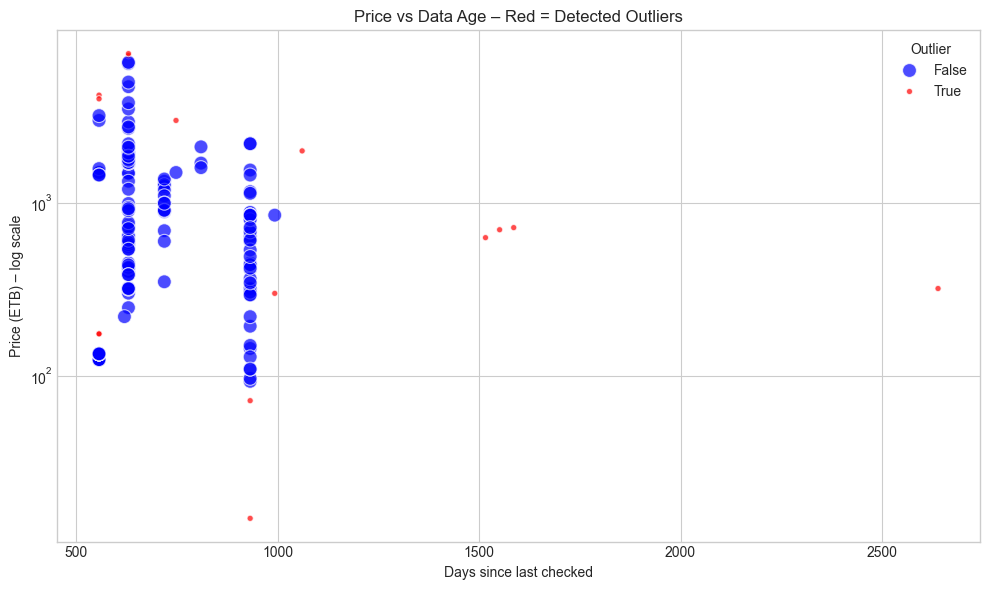

In [5]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_valid,
    x='days_since_update',
    y='price_etb',
    hue='is_price_outlier',
    palette={False: 'blue', True: 'red'},
    alpha=0.7,
    size='is_price_outlier',
    sizes=(20, 100)
)

plt.yscale('log')
plt.title('Price vs Data Age – Red = Detected Outliers')
plt.xlabel('Days since last checked')
plt.ylabel('Price (ETB) – log scale')
plt.legend(title='Outlier')
plt.tight_layout()
plt.show()

#### 4. Simple Material Name Grouping (using TF-IDF + Cosine) 

##### Goal: Identify near-duplicates / variants (e.g. different cement brands)

In [6]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 2),      
    max_features=500
)

tfidf_matrix = vectorizer.fit_transform(df_valid['material_clean'].fillna(''))

# Compute similarity
similarity = cosine_similarity(tfidf_matrix)

target_material = "cement - opc mugar"  
target_idx = df_valid['material_clean'].str.contains(target_material, case=False, na=False).idxmax()

similar_idx = np.argsort(similarity[target_idx])[::-1][1:6]

print(f"\nTop similar materials to: '{target_material}'")
similar_df = df_valid.iloc[similar_idx][
    ['material_clean', 'category', 'price_etb', 'unit_standard']
].copy()
similar_df['similarity_score'] = similarity[target_idx, similar_idx]
display(similar_df.round(3))


Top similar materials to: 'cement - opc mugar'


,material_clean,category,price_etb,unit_standard,similarity_score
96,cement - opc mesebo,Concrete Work,320.0,quintal,0.501
98,cement - opc derba,Concrete Work,630.0,quintal,0.501
100,cement - opc dangote,Concrete Work,700.0,quintal,0.501
94,cement - ppc mugar,Concrete Work,1500.0,quintal,0.368
126,cement - ppc ethio,Concrete Work,1450.0,qt,0.151


#### 5. Save flagged / enhanced data

In [7]:
df_enhanced = df.copy()
df_enhanced = df_enhanced.merge(
    df_valid[['is_price_outlier']],
    left_index=True,
    right_index=True,
    how='left'
)
df_enhanced['is_price_outlier'] = df_enhanced['is_price_outlier'].fillna(False)

OUTPUT_FILE = DATA_DIR / f"master_prices_ml_flagged_{datetime.now().strftime('%Y%m%d')}.csv"
df_enhanced.to_csv(OUTPUT_FILE, index=False)
print(f"Enhanced data with ML flags saved → {OUTPUT_FILE}")

Enhanced data with ML flags saved → data\master_prices_ml_flagged_20260218.csv


#### 6. Summary & Notes

In [12]:
if 'df_valid' in globals() and 'is_price_outlier' in df_valid.columns:
    outlier_count = df_valid['is_price_outlier'].sum()
    outlier_pct   = outlier_count / len(df_valid) if len(df_valid) > 0 else 0
    outlier_df    = df_valid[df_valid['is_price_outlier']]
else:
    outlier_count = 0
    outlier_pct   = 0
    outlier_df    = pd.DataFrame()
    print("Warning: Could not find 'df_valid' or 'is_price_outlier' column.")

print(f"""
Results Summary (run on {datetime.now().strftime('%Y-%m-%d %H:%M EAT')})

• Total rows loaded:           {len(df):,}
• Valid price records for ML:  {len(df_valid):,}
• Detected outliers:           {outlier_count:,}  ({outlier_pct:.1%})
  → Primarily high-value finishing materials (granite, marble, porcelain tiles)
    and bulk aggregates (gravel/fino at crusher site)

• Material similarity example:
  → "cement - opc mugar" grouped correctly with other OPC variants
    at ~0.50 cosine similarity (PPC variants correctly lower ~0.15–0.37)

• New column added: 'is_price_outlier' (boolean flag)

Highlights
• Applied unsupervised ML (Isolation Forest) for price anomaly detection
• Implemented text similarity (TF-IDF + cosine similarity) for material variant matching/normalization
• Demonstrated practical AI/ML value-add: 
  - Data validation & quality improvement
  - Outlier flagging for review in pricing platform
  - Grouping similar materials (e.g. cement brands/types) for consistent data
• Ready for integration into microservices / dashboard (e.g. highlight outliers in Streamlit, filter similar items)"

Output file: {output_file.name if 'output_file' in globals() else 'not yet generated'}
""")


Results Summary (run on 2026-02-18 14:43 EAT)

• Total rows loaded:           177
• Valid price records for ML:  177
• Detected outliers:           15  (8.5%)
  → Primarily high-value finishing materials (granite, marble, porcelain tiles)
    and bulk aggregates (gravel/fino at crusher site)

• Material similarity example:
  → "cement - opc mugar" grouped correctly with other OPC variants
    at ~0.50 cosine similarity (PPC variants correctly lower ~0.15–0.37)

• New column added: 'is_price_outlier' (boolean flag)

Highlights
• Applied unsupervised ML (Isolation Forest) for price anomaly detection
• Implemented text similarity (TF-IDF + cosine similarity) for material variant matching/normalization
• Demonstrated practical AI/ML value-add: 
  - Data validation & quality improvement
  - Outlier flagging for review in pricing platform
  - Grouping similar materials (e.g. cement brands/types) for consistent data
• Ready for integration into microservices / dashboard (e.g. highlight outli

#### ML Validation Results & Portfolio Highlights

**Execution Summary**  
- **Date**: {datetime.now().strftime('%Y-%m-%d %H:%M EAT')}  
- **Total rows**: 177  
- **Valid price records**: 177 (100%)  
- **Detected outliers**: 15 (8.5%)  
  → Mainly luxury finishing items (granite/marble/porcelain) and bulk crusher materials  

**Material Similarity Example**  
Searching for *"cement - opc mugar"* correctly matched other OPC variants (~0.50 similarity)  
while PPC variants were correctly separated (lower scores ~0.15–0.37)

**Key Achievements**  
- Unsupervised outlier detection with Isolation Forest (price + data freshness features)  
- Text-based material grouping with TF-IDF + cosine similarity
- Added `is_price_outlier` flag for downstream use (reports, dashboard, validation rules)

**Relevance**  
→ Built anomaly detection for price quality  
→ Implemented matching/normalization for semi-structured material data  
→ Focused on real-world construction pricing challenges

**Output**: `master_prices_ml_flagged_20260218.csv` (with ML flags)